In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import time
import mani_skill.env
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style


#####################  hyper parameters  ####################

MAX_EPISODES = 700               # 最大训练代数
MAX_EP_STEPS = 200               # episode最大持续帧数

RENDER = True

LOAD_MEM = False
LOAD_MODEL = False
LOAD_FOLDER_NAME = 'carbinet_1000epi'

LOAD_PRETRAIN = True


ENV_NAME = 'OpenCabinetDrawer-v0'         # 游戏名称
SEED = 123                       # 随机数种子

var = 5
var_low_bound = 0.001

In [10]:
###############################  DDPG  ####################################
class DDPG(object):
    def __init__(self, a_dim, s_dim, a_bound,):
        self.a_dim = a_dim
        self.s_dim = s_dim
        self.a_bound = a_bound
        self.pointer = 0                                                                         # exp buffer指针
        self.lr_a = 0.001                                                                        # learning rate for actor
        self.lr_c = 0.002                                                                        # learning rate for critic
        self.gamma = 0.9                                                                         # reward discount
        self.tau = 0.01                                                                          # 软更新比例
        self.memory_capacity = 10000
        self.batch_size = 32
        self.memory = np.zeros((self.memory_capacity, s_dim * 2 + a_dim + 1), dtype=np.float32)

        self.Reward_record = []
        
        class ANet(nn.Module):                               # 定义动作网络
            def __init__(self, s_dim, a_dim, a_bound):
                super(ANet,self).__init__()
                self.a_bound = a_bound
                self.fc1 = nn.Linear(s_dim,256)
                self.fc1.weight.data.normal_(0,0.1)          # initialization
                
                self.fc2 = nn.Linear(256,512)
                self.fc2.weight.data.normal_(0,0.1)
                               
                self.fc3 = nn.Linear(512,256)
                self.fc3.weight.data.normal_(0,0.1)
                
                self.out = nn.Linear(256,a_dim)
                self.out.weight.data.normal_(0,0.1)          # initialization
            def forward(self,x):
                x = self.fc1(x)
                x = F.relu(x)
                
                x = self.fc2(x)
                x = F.relu(x)
                
                x = self.fc3(x)
                x = F.relu(x)
                
                x = self.out(x)
                x = F.tanh(x)
                actions_value = x * a_bound
                return actions_value

        class CNet(nn.Module):                               # 定义价值网络
            def __init__(self,s_dim,a_dim):
                super(CNet,self).__init__()
                self.fcs1 = nn.Linear(s_dim,256)
                self.fcs1.weight.data.normal_(0,0.1)          # initialization
                
                self.fcs2 = nn.Linear(256,512)
                self.fcs2.weight.data.normal_(0,0.1) 
                
                self.fcs3 = nn.Linear(512,256)
                self.fcs3.weight.data.normal_(0,0.1) 
                
                self.fca1 = nn.Linear(a_dim,256)
                self.fca1.weight.data.normal_(0,0.1)          # initialization
                
                self.fca2 = nn.Linear(256,512)
                self.fca2.weight.data.normal_(0,0.1)                
                
                self.fca3 = nn.Linear(512,256)
                self.fca3.weight.data.normal_(0,0.1)
                
                self.out = nn.Linear(256,1)
                self.out.weight.data.normal_(0, 0.1)         # initialization
            def forward(self,s,a):
                x = self.fcs1(s)                              # 输入状态
                x = F.relu(x)
                
                x = self.fcs2(x)
                x = F.relu(x)
                
                x = self.fcs3(x)
                x = F.relu(x) 
                
                y = self.fca1(a)                              # 输入动作
                y = F.relu(y)
                
                y = self.fca2(y)                              
                y = F.relu(y)
                
                y = self.fca3(y)                              
                y = F.relu(y)
                
                net = F.relu(x+y)
                actions_value = self.out(net)                # 给出V(s,a)
                return actions_value

        self.Actor_eval = ANet(s_dim, a_dim, a_bound)        # 主网络
        self.Actor_target = ANet(s_dim, a_dim, a_bound)      # 目标网络
        self.Critic_eval = CNet(s_dim, a_dim)                # 主网络
        self.Critic_target = CNet(s_dim, a_dim)              # 当前网络
        self.ctrain = torch.optim.Adam(self.Critic_eval.parameters(),lr = self.lr_c) # critic的优化器
        self.atrain = torch.optim.Adam(self.Actor_eval.parameters(),lr = self.lr_a)  # actor的优化器
        self.loss_td = nn.MSELoss()                          # 损失函数采用均方误差

    def choose_action(self, s):
        s = torch.unsqueeze(torch.FloatTensor(s), 0)
        #print('choose action: ',self.Actor_eval(s))
        #print('choose action 0 : ', self.Actor_eval(s)[0])
        #print('forward: ',self.Actor_eval.forward(s))
        #return self.Actor_eval(s)[0].detach()                # detach()不需要计算梯度
        return self.Actor_eval.forward(s)[0].detach()

    def learn(self):

        for x in self.Actor_target.state_dict().keys():
            eval('self.Actor_target.' + x + '.data.mul_((1 - self.tau))')  
            eval('self.Actor_target.' + x + '.data.add_(self.tau * self.Actor_eval.' + x + '.data)')
        for x in self.Critic_target.state_dict().keys():
            eval('self.Critic_target.' + x + '.data.mul_((1- self.tau))')
            eval('self.Critic_target.' + x + '.data.add_(self.tau * self.Critic_eval.' + x + '.data)')

        # soft target replacement

        indices = np.random.choice(self.memory_capacity, size = self.batch_size)  # 随机采样的index
        bt = self.memory[indices, :]                                              # 采样batch_size个sample
        bs = torch.FloatTensor(bt[:, :self.s_dim])                                # state
        ba = torch.FloatTensor(bt[:, self.s_dim: self.s_dim + self.a_dim])        # action
        br = torch.FloatTensor(bt[:, -self.s_dim - 1: -self.s_dim])               # reward
        bs_ = torch.FloatTensor(bt[:, -self.s_dim:])                              # next state

        a = self.Actor_eval(bs)
        q = self.Critic_eval(bs,a)  # loss=-q=-ce(s,ae(s))更新ae   ae(s)=a   ae(s_)=a_
        # 如果 a是一个正确的行为的话，那么它的Q应该更贴近0
        loss_a = -torch.mean(q) 
        # print(q)
        # print(loss_a)
        self.atrain.zero_grad()
        loss_a.backward()
        self.atrain.step()

        a_ = self.Actor_target(bs_)      # 这个网络不及时更新参数, 用于预测 Critic 的 Q_target 中的 action
        q_ = self.Critic_target(bs_,a_)  # 这个网络不及时更新参数, 用于给出 Actor 更新参数时的 Gradient ascent 强度
        q_target = br + self.gamma * q_  # q_target = 负的
        #print(q_target)
        q_v = self.Critic_eval(bs,ba)
        #print(q_v)
        td_error = self.loss_td(q_target,q_v)
        # td_error = R + self.gamma * ct（bs_,at(bs_)）-ce(s,ba) 更新ce ,但这个ae(s)是记忆中的ba，让ce得出的Q靠近Q_target,让评价更准确
        #print(td_error)
        self.ctrain.zero_grad()
        td_error.backward()
        self.ctrain.step()

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % self.memory_capacity     # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1                               # 指示sample位置的指针+1
    
    def store_reward(self,ep_reward):
        self.Reward_record.append(ep_reward)
        
    def save(self,folder_name):
    
        os.mkdir('./DPG model/' + folder_name)
    
        PATH1 = './DPG model/' + folder_name + '/Actor_eval.h5f'
        PATH2 = './DPG model/' + folder_name + '/Actor_target.h5f'
        PATH3 = './DPG model/' + folder_name + '/Critic_eval.h5f'
        PATH4 = './DPG model/' + folder_name + '/Critic_target.h5f'
    
        torch.save(self.Actor_eval.state_dict(), PATH1)
        torch.save(self.Actor_target.state_dict(), PATH2)
        torch.save(self.Critic_eval.state_dict(), PATH3)
        torch.save(self.Critic_target.state_dict(), PATH4)
    
        csv_name='./DPG model/' + folder_name + '/memory.csv'
        xml_df = pd.DataFrame(self.memory)
        xml_df.to_csv(csv_name, index = None, columns= None)
        
        csv_name='./DPG model/' + folder_name + '/Rewards.csv'
        xml_df = pd.DataFrame(self.Reward_record)
        xml_df.to_csv(csv_name, index = None, columns= None)
        
    def plot_file_rewards(self, folder_name):
        data = pd.read_csv('./DPG model/' + folder_name + '/Rewards.csv')
        y = np.array(data).squeeze()
        x = range(y.shape[0])
        plt.figure(figsize=(10, 10), dpi=70)
        #plt.plot(x, y)
        plt.scatter(x, y)
        plt.show()
    
    def plot_rewards(self, scatter):
        y = self.Reward_record
        x = range(len(y))
        plt.figure(figsize=(10, 10), dpi=70)
        
        if scatter:
            plt.scatter(x, y)
        else:
            plt.plot(x, y)
        plt.show()
    
    def load_model(self):
        self.Actor_eval.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Actor_eval.h5f'))
        self.Actor_eval.eval()
        self.Actor_target.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Actor_target.h5f'))
        self.Actor_target.eval()
        self.Critic_eval.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Critic_eval.h5f'))
        self.Critic_eval.eval()
        self.Critic_target.load_state_dict(torch.load('./DPG model/' + LOAD_FOLDER_NAME + '/Critic_target.h5f'))
        self.Critic_target.eval()
        print("Load network parameters of: " + LOAD_FOLDER_NAME) 
        
    def load_memory(self):
        data = pd.read_csv('./DPG model/' + LOAD_FOLDER_NAME + '/memory.csv')
        self.memory = np.array(data)
        print("Load memory of: " + LOAD_FOLDER_NAME)

In [11]:
###############################  training  ####################################
env = gym.make(ENV_NAME)
env = env.unwrapped
env.seed(SEED)                                          # 设置Gym的随机数种子
torch.manual_seed(SEED)                                 # 设置pytorch的随机数种子

env.set_env_mode(obs_mode='state', reward_type='dense')

s_dim = env.observation_space.shape[0]                  # 状态空间
a_dim = env.action_space.shape[0]                       # 动作空间
a_bound = 1                         # 动作取值区间,对称区间，故只取上界
ddpg = DDPG(a_dim, s_dim, a_bound)

if LOAD_MODEL:
    ddpg.load_model()

    
if LOAD_MEM:
    ddpg.load_memory()

if LOAD_PRETRAIN:
    ddpg.Actor_eval.load_state_dict(torch.load('./DPG model/pretrain/Actor_eval.h5f'))
    ddpg.Actor_eval.eval()
    ddpg.Actor_target.load_state_dict(torch.load('./DPG model/pretrain/Actor_eval.h5f'))
    ddpg.Actor_target.eval() 

if LOAD_MODEL or LOAD_MEM:
    var = 0.5

if LOAD_PRETRAIN:
    var = 0.01
    
t1 = time.time()                                        # 开始时间

for i in range(MAX_EPISODES):
    s = env.reset(level = 1)
    ep_reward = 0
    for j in range(MAX_EP_STEPS):
        if RENDER:
            env.render('human')

        # Add exploration noise
        a = ddpg.choose_action(s)

        a = np.clip(np.random.normal(a, var), -1, 1)    # add randomness to action selection for exploration

        s_, r, done, info = env.step(a)
        
        info_ = info.get('eval_info')
        if info_.get('open_enough'):
            print("!!!!!!!!!!!!!yeah!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            r += 10000
        r += 7
        
        ddpg.store_transition(s, a, r, s_)         # 为什么要对reward归一化

        if ddpg.pointer > ddpg.memory_capacity or LOAD_MEM:         # 经验池已满
            if var > var_low_bound:
                var *= .9995                            # 学习阶段逐渐降低动作随机性decay the action randomness
            ddpg.learn()                                # 开始学习

        s = s_
        ep_reward += r
        if j == MAX_EP_STEPS-1 or done:
            print('Episode:', i, ' Reward: %i' % int(ep_reward), 'Explore: %.2f' % var, )
            
            ddpg.store_reward(ep_reward)
            
            if ep_reward > -300 or i == (MAX_EPISODES - 5):
                RENDER = True
                
            break
               
print('Running time: ', time.time() - t1)

Episode: 0  Reward: -969 Explore: 0.01
Episode: 1  Reward: -1218 Explore: 0.01
Episode: 2  Reward: -1009 Explore: 0.01
Episode: 3  Reward: -1021 Explore: 0.01
Episode: 4  Reward: -1085 Explore: 0.01
Episode: 5  Reward: -1007 Explore: 0.01
Episode: 6  Reward: -1013 Explore: 0.01
Episode: 7  Reward: -1007 Explore: 0.01
Episode: 8  Reward: -1048 Explore: 0.01
Episode: 9  Reward: -1050 Explore: 0.01
Episode: 10  Reward: -990 Explore: 0.01
Episode: 11  Reward: -1057 Explore: 0.01
Episode: 12  Reward: -980 Explore: 0.01
Episode: 13  Reward: -996 Explore: 0.01
Episode: 14  Reward: -1026 Explore: 0.01
Episode: 15  Reward: -1163 Explore: 0.01
Episode: 16  Reward: -1187 Explore: 0.01
Episode: 17  Reward: -1065 Explore: 0.01
Episode: 18  Reward: -1062 Explore: 0.01
Episode: 19  Reward: -1030 Explore: 0.01
Episode: 20  Reward: -985 Explore: 0.01
Episode: 21  Reward: -1180 Explore: 0.01
Episode: 22  Reward: -985 Explore: 0.01
Episode: 23  Reward: -1003 Explore: 0.01
Episode: 24  Reward: -997 Explor

AttributeError: 'NoneType' object has no attribute 'set_scene'

In [11]:
ddpg.save('carbinet_1000epi')

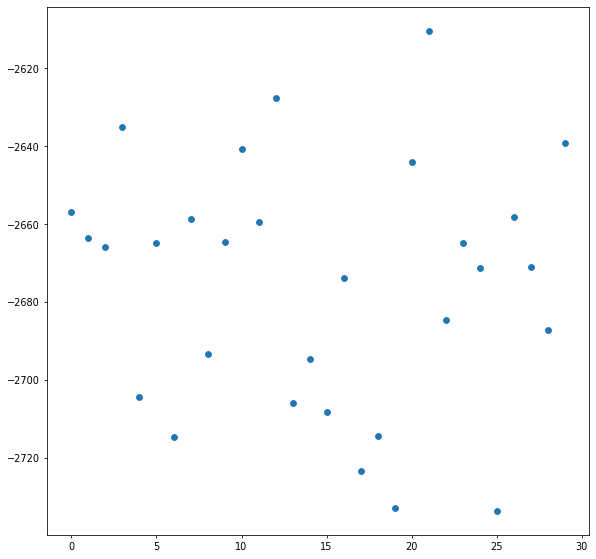

In [28]:
ddpg.plot_rewards(scatter = True)

In [34]:
a_dim

13

In [7]:
info

{'eval_info': {'cabinet_static': True, 'open_enough': False, 'success': False},
 'dist_ee_to_handle': array([1.32828861, 1.30526796]),
 'angle1': 1.1766494349134005,
 'angle2': 1.5317321746066244,
 'dist_ee_mid_to_handle': -1.3160184768477239,
 'rew_ee_handle': -2.6335565692093796,
 'rew_ee_mid_handle': -1.0,
 'qpos_rew': 0,
 'qvel_rew': 0,
 'gripper_angle_err': 67.4170465869911,
 'gripper_angle_rew': -1.1236174431165185,
 'gripper_vel_norm': 0.0,
 'gripper_ang_vel_norm': 0.0,
 'qpos': 0.0,
 'qvel': 0.0,
 'target_qpos': 0.23135713040828706,
 'reward_raw': -6.757174012325898,
 'stage_reward': -7.0,
 'TimeLimit.truncated': True}

In [8]:
done

True